In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

#eval metrics
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR

Importamos el dataset y creamos un dataframe con dos columnas: el tiempo y el parámetro del viento a estudiar. En este caso, hemos introducido la Wind Speed.

In [2]:
# get the dataset
dataset = pd.read_csv('tfgdatos.csv', encoding='utf-8',skiprows=lambda x: (x != 0) and not x % 2)
# our dataset in this implementation is small, and thus we can print it all instead of viewing only the end
print(dataset)
X = np.empty(shape=25265)
#d = np.arange(0,505300, 10)
#X = np.row_stack(d)
i = 0
for i in range (25265):
  X[i] = i*20


d = {'Date/Time': X, 'Wind Speed (m/s)': dataset['Wind Direction (°)']}
df = pd.DataFrame(data = d)
df

              Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0      01 01 2018 00:00           380.047791          5.311336   
1      01 01 2018 00:20           306.376587          5.216037   
2      01 01 2018 00:40           380.650696          5.577941   
3      01 01 2018 01:00           447.605713          5.793008   
4      01 01 2018 01:20           463.651215          5.584629   
...                 ...                  ...               ...   
25260  31 12 2018 22:20          2771.110107         10.154550   
25261  31 12 2018 22:40          3455.282959         12.195660   
25262  31 12 2018 23:00          3514.269043         12.559170   
25263  31 12 2018 23:20          1684.353027          7.332648   
25264  31 12 2018 23:40          2515.694092          9.421366   

       Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                         416.328908          259.994904  
1                         390.900016          272.564789  
2                         491.

,Date/Time,Wind Speed (m/s)
0,0.0,259.994904
1,20.0,272.564789
2,40.0,265.674286
3,60.0,266.163605
4,80.0,253.480698
...,...,...
25260,505200.0,82.335197
25261,505220.0,82.210617
25262,505240.0,80.495262
25263,505260.0,84.062599


En este caso, vamos a probar a realizar una predicción de 1 día con 1 semana de entrenamiento. Para ello, vamos a coger los últimos 72 + 504 datos (testing y training data respectivamente)

In [3]:
#504+72
X = df.iloc[24689:, 0:1].values
y = df.iloc[24689:, 1].values

Escalamos los datos

In [4]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y.reshape(-1,1))

Separamos los datos en train (504) y test (72)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.125, random_state = 42, shuffle=False)
X_test.shape

(72, 1)

La siguiente función consiste en una búsqueda de los parámetros con los mejores resultados para nuestros datos actuales. Prueba diferentes valores para los 2 de los 3 parámetros a tener en cuenta en nuestro modelo. El parámetro C, como hemos podido observar en el código principal del proyecto, siempre es mejor si, de todas las opciones, escogemos C = 1. Aquí lo hemos escogido directamente.

In [6]:
#comprobación de los mejores parámetros
def best_params():
    epsilons = np.arange(0.1, 1.1, 0.2) 
    gammas = ['scale', 'auto']
    best_gamma = -1
    best_epsilon = -1
    mejor_error = 10
    First = True

    for e in epsilons: #comprobamos la mejor epsilon
        for g in gammas: #comprobamos la mejor gamma
            regressor = SVR(kernel = 'rbf', C = 1, epsilon = e, gamma = g, verbose = False)
            regressor.fit(X_train, y_train.ravel())
            pred = regressor.predict(X_test)
            error = mean_squared_error(sc_y.inverse_transform(y_test), sc_y.inverse_transform(pred), squared= False)
            print("EPSILON, GAMMA: ")
            print(e)
            print(g)
            print(error)
            if error < mejor_error or First:
                if First == True: First = False
                mejor_error = error
                best_gamma = g
                best_epsilon = e
                    
    return best_epsilon,best_gamma

In [7]:
e,g = best_params()

EPSILON, GAMMA: 
0.1
scale
116.83964759990265
EPSILON, GAMMA: 
0.1
auto
150.65622392388158
EPSILON, GAMMA: 
0.30000000000000004
scale
113.08138793669329
EPSILON, GAMMA: 
0.30000000000000004
auto
126.48623956541569
EPSILON, GAMMA: 
0.5000000000000001
scale
90.76001926629371
EPSILON, GAMMA: 
0.5000000000000001
auto
101.25970108839194
EPSILON, GAMMA: 
0.7000000000000001
scale
76.27408520882697
EPSILON, GAMMA: 
0.7000000000000001
auto
77.33767153466776
EPSILON, GAMMA: 
0.9000000000000001
scale
77.72671735490684
EPSILON, GAMMA: 
0.9000000000000001
auto
73.20954707142488


In [8]:
print(e)
print(g)

0.9000000000000001
auto


Entrenamos el algoritmo y predecimos los datos de testeo. Epsilon y gamma deberían corresponder a los mejores parámetros devueltos por la función best_parameters().

In [9]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf', C = 1, epsilon = e, gamma=g, verbose = False)
regressor.fit(X_train, y_train.ravel())
pred = regressor.predict(X_test)

Calculamos el RMSE:

In [10]:
error = mean_squared_error(sc_y.inverse_transform(y_test),sc_y.inverse_transform(pred.reshape(-1,1)), squared= False) #calculate rmse
error

73.20954707142488

In [11]:
r2(sc_y.inverse_transform(y_test), sc_y.inverse_transform(pred.reshape(-1,1)))

0.001678430882805948

Por último, visualizamos las predicciones en gráficas. Hay dos diferentes: La primera muestra todos los datos (train y test) y una línea azul sobre ellos que corresponde a la predicción. La segunda se visualiza mejor puesto que utilizamos cuatro colores. El azul corresponde a los datos de entrenamiento, el verde claro a los datos de testeo y el verde oscuro y el rojo corresponden a sus respectivas predicciones.

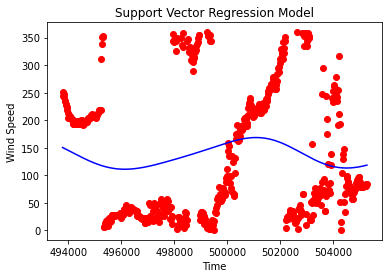

In [12]:
plt.scatter(sc_X.inverse_transform(X), sc_y.inverse_transform(y), color = 'red')
plt.plot(sc_X.inverse_transform(X), sc_y.inverse_transform(regressor.predict(X).reshape(-1,1)), color = 'blue')

plt.title('Support Vector Regression Model')
# label x 
plt.xlabel('Time')
# label y 
plt.ylabel('Wind Speed')

plt.show()

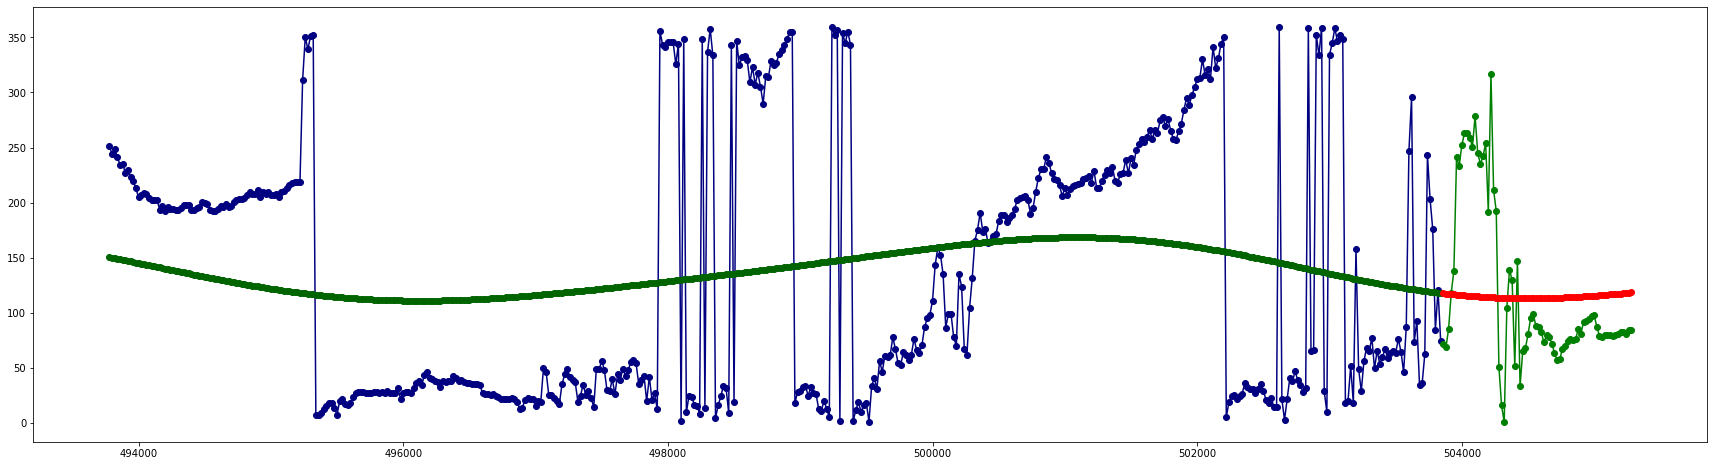

In [13]:
fig,ax = plt.subplots(figsize=(30,8))

# training data 
ax.plot(sc_X.inverse_transform(X_train),sc_y.inverse_transform(y_train),'navy',marker='o',label='observed')
# test data
ax.plot(sc_X.inverse_transform(X_test),sc_y.inverse_transform(y_test),'g',marker='o')
ax.plot(sc_X.inverse_transform(X_train),sc_y.inverse_transform(regressor.predict(X_train).reshape(-1,1)),'darkgreen',marker='o',label='pred')
ax.plot(sc_X.inverse_transform(X_test),sc_y.inverse_transform(regressor.predict(X_test).reshape(-1,1)),'red',marker='o',label='pred')

Por último, con esto podemos observar la evolución del error en una gráfica:

In [14]:
list_error = np.empty(len(X_test))

#invertimos el escalado para comprobar cuánto se alejan realmente las predicciones de los datos reales
pred_error = sc_y.inverse_transform(pred.reshape(-1,1))
y_error = sc_y.inverse_transform(y_test.reshape(-1,1))

for i in range (len(pred_error)):
  list_error[i] = abs(pred_error[i]-y_error[i])

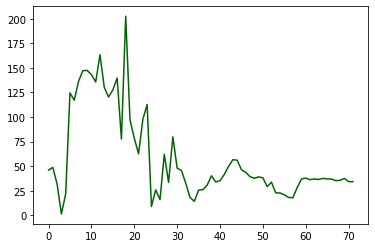

In [15]:
plt.plot(range(pred_error.size),list_error, 'darkgreen')